## Ethereum Price Prediction (SVM)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

In [2]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas_datareader.data as web
import datetime
from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

## Set up DataFrame

We'll use past Ethereum Market price data

In [58]:
eth = pd.read_csv('2019-02-27_2021-11-03_ethereumprice_org.csv')
eth = eth.sort_values('timestamp')
eth.reset_index(inplace=True)
eth.set_index("timestamp", inplace=True)

test_eth = pd.read_csv('2019-02-27_2021-11-03_ethereumprice_org.csv')
test_eth = test_eth.sort_values('timestamp')
test_eth.reset_index(inplace=True)
test_eth.set_index("timestamp", inplace=True)

In [34]:
eth.head()

,index,open,high,low,close
timestamp,,,,,
1551225600,1139,139.257611,141.0144428112453,128.10446528726902,136.028530813911
1551312000,1138,135.972363,140.81296395197484,134.90498394801122,136.6016635502296
1551398400,1137,136.707203,139.46023200559716,136.28057392270875,136.63115860635676
1551484800,1136,136.511373,137.37542468365848,131.56456360284588,133.41201623674613
1551571200,1135,134.596747,136.05465477687287,128.97629421106276,131.15585401658774


In [35]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1140 entries, 1551225600 to 1635897600
Data columns (total 5 columns):
index    1140 non-null int64
open     1140 non-null float64
high     1140 non-null object
low      1140 non-null object
close    1140 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 53.4+ KB


In [36]:
eth.describe()

,index,open
count,1140.000000,1140.000000
mean,569.500000,1118.733104
std,329.233959,1218.438370
min,0.000000,111.275258
25%,284.750000,193.906413
50%,569.500000,381.453748
75%,854.250000,1967.792534
max,1139.000000,4598.000000


In [37]:
eth.columns

Index(['index', 'open', 'high', 'low', 'close'], dtype='object')

# EDA

Let's create some simple plots to check out the data

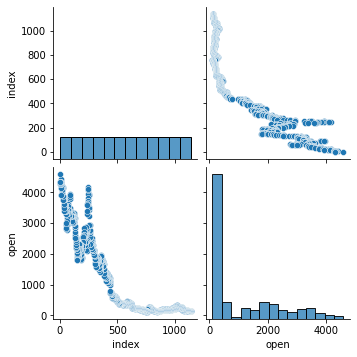

In [38]:
sns.pairplot(eth)

<AxesSubplot:xlabel='open', ylabel='Density'>

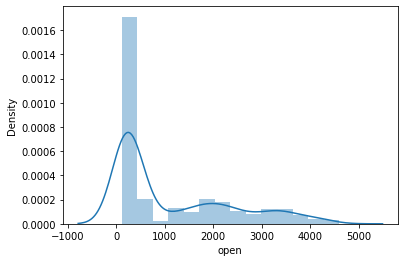

In [39]:
sns.distplot(eth['open'])

In [65]:
eth = eth[eth.high.str[:] != "undefined"]
eth = eth[eth.low.str[:] != "undefined"]
eth = eth[eth.close.str[:] != "undefined"]

test_eth = test_eth[test_eth.high.str[:] != "undefined"]
test_eth = test_eth[test_eth.low.str[:] != "undefined"]
test_eth = test_eth[test_eth.close.str[:] != "undefined"]

In [66]:
eth['open'] = eth['open'].astype(str).astype(float)
eth['high'] = eth['high'].astype(str).astype(float)
eth['low'] = eth['low'].astype(str).astype(float)
eth['close'] = eth['close'].astype(str).astype(float)

test_eth['open'] = test_eth['open'].astype(str).astype(float)
test_eth['high'] = test_eth['high'].astype(str).astype(float)
test_eth['low'] = test_eth['low'].astype(str).astype(float)
test_eth['close'] = test_eth['close'].astype(str).astype(float)

eth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 978 entries, 1551225600 to 1635811200
Data columns (total 5 columns):
index    978 non-null int64
open     978 non-null float64
high     978 non-null float64
low      978 non-null float64
close    978 non-null float64
dtypes: float64(4), int64(1)
memory usage: 85.8 KB


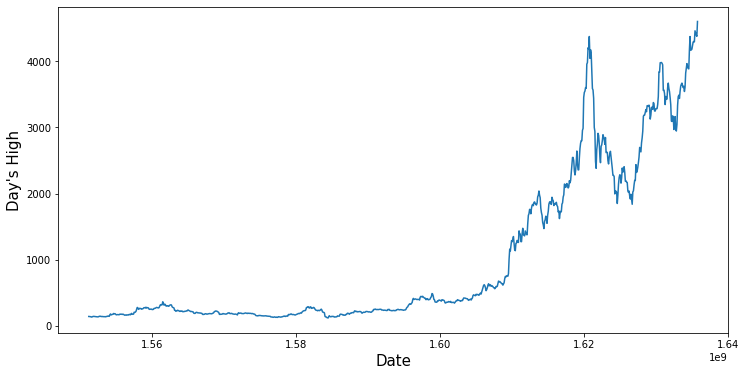

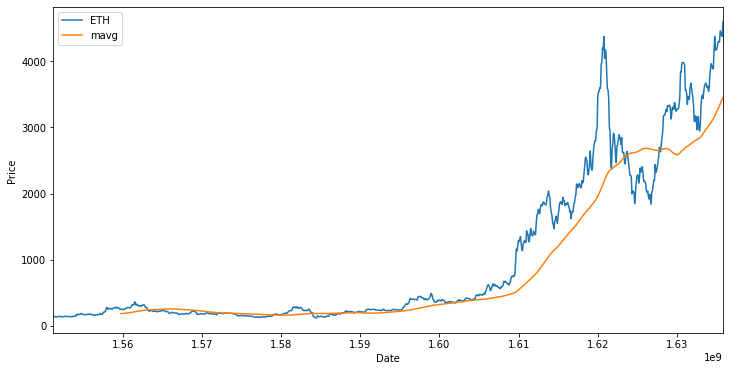

In [42]:
plt.figure(figsize = (12,6))
plt.plot(eth["high"])
plt.xlabel('Date',fontsize=15)
plt.ylabel("Day's High",fontsize=15)
plt.show()


# Rolling mean
close_px = eth['high']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='ETH')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

## SVR code using sklearn and visualizing kernels:


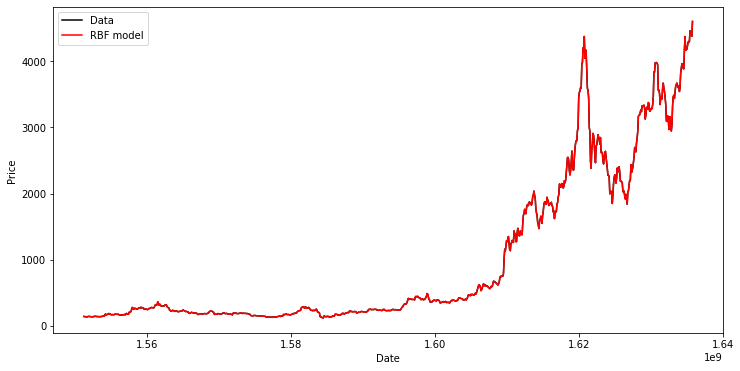

In [48]:
# Use sklearn support vector regression to predicit our data:
from sklearn.svm import SVR

dates_eth = eth.copy()
dates_eth = dates_eth.reset_index()

dates = dates_eth['timestamp'].as_matrix()
prices = dates_eth['high'].as_matrix()

org_dates = dates_eth['timestamp']

#Convert to 1d Vector
dates = np.reshape(dates, (len(dates), 1))
prices = np.reshape(prices, (len(prices), 1))

svr_rbf = SVR(kernel= 'rbf', C= 4e3, gamma= 0.1)
svr_rbf.fit(dates, prices)

plt.figure(figsize = (12,6))
plt.plot(dates, prices, color= 'black', label= 'Data')
plt.plot(org_dates, svr_rbf.predict(dates), color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Normalizing our data:


In [49]:
# Create train set of adj close prices data:
train_data = eth.loc[:,'high'].as_matrix()
print(train_data.shape) # 1258 


# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(978,)


## Preparing our data for the neural network

In [50]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
    
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)


# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(942, 36, 1)
X_train:
[[141.01444281]
 [140.81296395]
 [139.46023201]
 [137.37542468]
 [136.05465478]
 [131.66041797]
 [138.82316574]
 [141.4491591 ]
 [142.73259903]
 [140.4602767 ]
 [139.87430276]
 [138.46501191]
 [136.71083639]
 [135.87048033]
 [135.29578002]
 [135.48706279]
 [138.4199028 ]
 [145.1343672 ]
 [142.7       ]
 [144.66158492]
 [139.91717207]
 [140.12391688]
 [140.88255686]
 [137.96338003]
 [138.75294795]
 [137.66697428]
 [138.47      ]
 [135.77774461]
 [140.8686419 ]
 [140.26081351]
 [144.86213132]
 [147.11091562]
 [144.38418739]
 [144.01576619]
 [167.09377941]
 [179.06006071]]


y_train: [[164.59494647]]



In [68]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 19, batch_size = 10, validation_split=.30)

Epoch 1/19
66/66 [==============================] - 16s 86ms/step - loss: 7.6949e-04 - val_loss: 0.0047
Epoch 2/19
66/66 [==============================] - 3s 49ms/step - loss: 2.2653e-04 - val_loss: 0.0222
Epoch 3/19
66/66 [==============================] - 2s 35ms/step - loss: 1.6005e-04 - val_loss: 0.0050
Epoch 4/19
66/66 [==============================] - 2s 32ms/step - loss: 1.5626e-04 - val_loss: 0.0133
Epoch 5/19
66/66 [==============================] - 2s 33ms/step - loss: 1.0805e-04 - val_loss: 0.0221
Epoch 6/19
66/66 [==============================] - 2s 32ms/step - loss: 1.3029e-04 - val_loss: 0.0161
Epoch 7/19
66/66 [==============================] - 2s 32ms/step - loss: 9.7827e-05 - val_loss: 0.0076
Epoch 8/19
66/66 [==============================] - 2s 32ms/step - loss: 1.2780e-04 - val_loss: 0.0049
Epoch 9/19
66/66 [==============================] - 2s 30ms/step - loss: 9.9993e-05 - val_loss: 0.0047
Epoch 10/19
66/66 [==============================] - 2s 31ms/step - loss

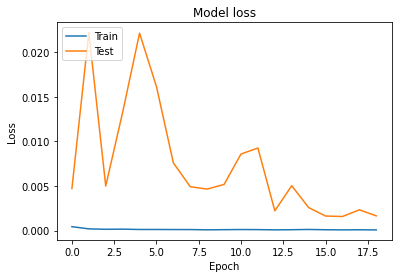

In [69]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

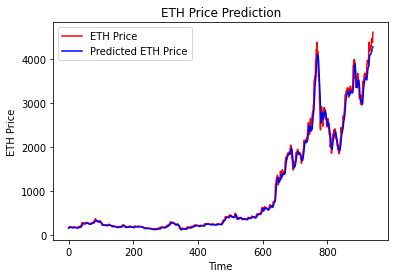

In [70]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_eth['high'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)


# plot the results 
plt.plot(org_y, color = 'red', label = 'ETH Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted ETH Price')
plt.title('ETH Price Prediction')
plt.xlabel('Time')
plt.ylabel('ETH Price')
plt.legend()
plt.show()